In [6]:
#import packages and libraries
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.api as sm 
from scipy import stats
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

#load data onto the Jupyter notebook
df = pd.read_csv('medical_clean.csv', index_col=0)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 49 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer_id         10000 non-null  object 
 1   Interaction         10000 non-null  object 
 2   UID                 10000 non-null  object 
 3   City                10000 non-null  object 
 4   State               10000 non-null  object 
 5   County              10000 non-null  object 
 6   Zip                 10000 non-null  int64  
 7   Lat                 10000 non-null  float64
 8   Lng                 10000 non-null  float64
 9   Population          10000 non-null  int64  
 10  Area                10000 non-null  object 
 11  TimeZone            10000 non-null  object 
 12  Job                 10000 non-null  object 
 13  Children            10000 non-null  int64  
 14  Age                 10000 non-null  int64  
 15  Income              10000 non-null  float64
 16  Marital  

In [7]:
#drop columns that are not related to the research question
df = df.drop(columns=['Customer_id', 'Interaction', 'UID', 'City', 'State', 'County', 'Zip', 'Lat', 'Lng', 'Population', 'TimeZone', 'Job', 'Income', 'Children', 'Marital', 'Doc_visits', 'Full_meals_eaten', 'vitD_supp','Soft_drink', 'Anxiety', 'Allergic_rhinitis', 'Reflux_esophagitis', 'Asthma', 'TotalCharge', 'Item1', 'Item2', 'Item3', 'Item4', 'Item5', 'Item6', 'Item7', 'Item8'])

#visually inspect df to facilitate exploration, spot problems
pd.set_option('display.max_columns', None)
df

,Area,Age,Gender,ReAdmis,VitD_levels,Initial_admin,HighBlood,Stroke,Complication_risk,Overweight,Arthritis,Diabetes,Hyperlipidemia,BackPain,Services,Initial_days,Additional_charges
CaseOrder,,,,,,,,,,,,,,,,,
1,Suburban,53,Male,No,19.141466,Emergency Admission,Yes,No,Medium,No,Yes,Yes,No,Yes,Blood Work,10.585770,17939.403420
2,Urban,51,Female,No,18.940352,Emergency Admission,Yes,No,High,Yes,No,No,No,No,Intravenous,15.129562,17612.998120
3,Suburban,53,Female,No,18.057507,Elective Admission,Yes,No,Medium,Yes,No,Yes,No,No,Blood Work,4.772177,17505.192460
4,Suburban,78,Male,No,16.576858,Elective Admission,No,Yes,Medium,No,Yes,No,No,No,Blood Work,1.714879,12993.437350
5,Rural,22,Female,No,17.439069,Elective Admission,No,No,Low,No,No,No,Yes,No,CT Scan,1.254807,3716.525786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,Urban,25,Male,No,16.980860,Emergency Admission,Yes,No,Medium,No,No,No,No,No,Intravenous,51.561220,8927.642000
9997,Urban,87,Male,Yes,18.177020,Elective Admission,Yes,No,Medium,Yes,Yes,Yes,No,No,CT Scan,68.668240,28507.150000
9998,Rural,45,Female,Yes,17.129070,Elective Admission,Yes,No,High,Yes,No,No,No,No,Intravenous,70.154180,15281.210000


In [8]:
#detection of duplicates True is missing value detected
df.duplicated()

CaseOrder
1        False
2        False
3        False
4        False
5        False
         ...  
9996     False
9997     False
9998     False
9999     False
10000    False
Length: 10000, dtype: bool

In [9]:
#count True and False together
print(df.duplicated().value_counts())

False    10000
Name: count, dtype: int64


In [10]:
#detect missing values
df.isnull().sum()

Area                  0
Age                   0
Gender                0
ReAdmis               0
VitD_levels           0
Initial_admin         0
HighBlood             0
Stroke                0
Complication_risk     0
Overweight            0
Arthritis             0
Diabetes              0
Hyperlipidemia        0
BackPain              0
Services              0
Initial_days          0
Additional_charges    0
dtype: int64

In [11]:
#check for outliers and remove them
print(df.shape)
df = df[(np.abs(stats.zscore(df.select_dtypes(include=np.number))) < 3).all(axis=1)]
print(df.shape)

(10000, 17)
(9976, 17)


In [12]:
#convert ReAdmis, Stroke, Arthritis, Diabetes, HighBlood, Overweight, Hyperlipidemia, and BackPain from string to boolean
bool_mapping = {"Yes": 1, "No": 0}

columns_to_convert = ["ReAdmis", "Stroke", "Arthritis", "Diabetes", "HighBlood", "Overweight", "Hyperlipidemia", "BackPain"]
for column in columns_to_convert:
    df.loc[:, column] = df[column].map(bool_mapping)

#convert Area, Gender, Initial_admin, Complication_risk, Services to category from string
category_columns = ["Area", "Gender", "Initial_admin", "Complication_risk", "Services"]
for column in category_columns:
    df.loc[:, column] = df[column].astype("category")

In [13]:
#get summary statistics for quantitative variables 
df.describe()

,Age,VitD_levels,Initial_days,Additional_charges
count,9976.000000,9976.000000,9976.000000,9976.000000
mean,53.499599,17.961542,34.442217,12928.740381
std,20.643570,1.992118,26.307773,6542.851751
min,18.000000,11.966340,1.001981,3125.703000
25%,36.000000,16.629534,7.896215,7977.009525
50%,53.000000,17.950096,34.446941,11564.474150
75%,71.000000,19.342284,61.157380,15613.047345
max,89.000000,23.941426,71.981490,30566.070000


array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'VitD_levels'}>],
       [<Axes: title={'center': 'Initial_days'}>,
        <Axes: title={'center': 'Additional_charges'}>]], dtype=object)

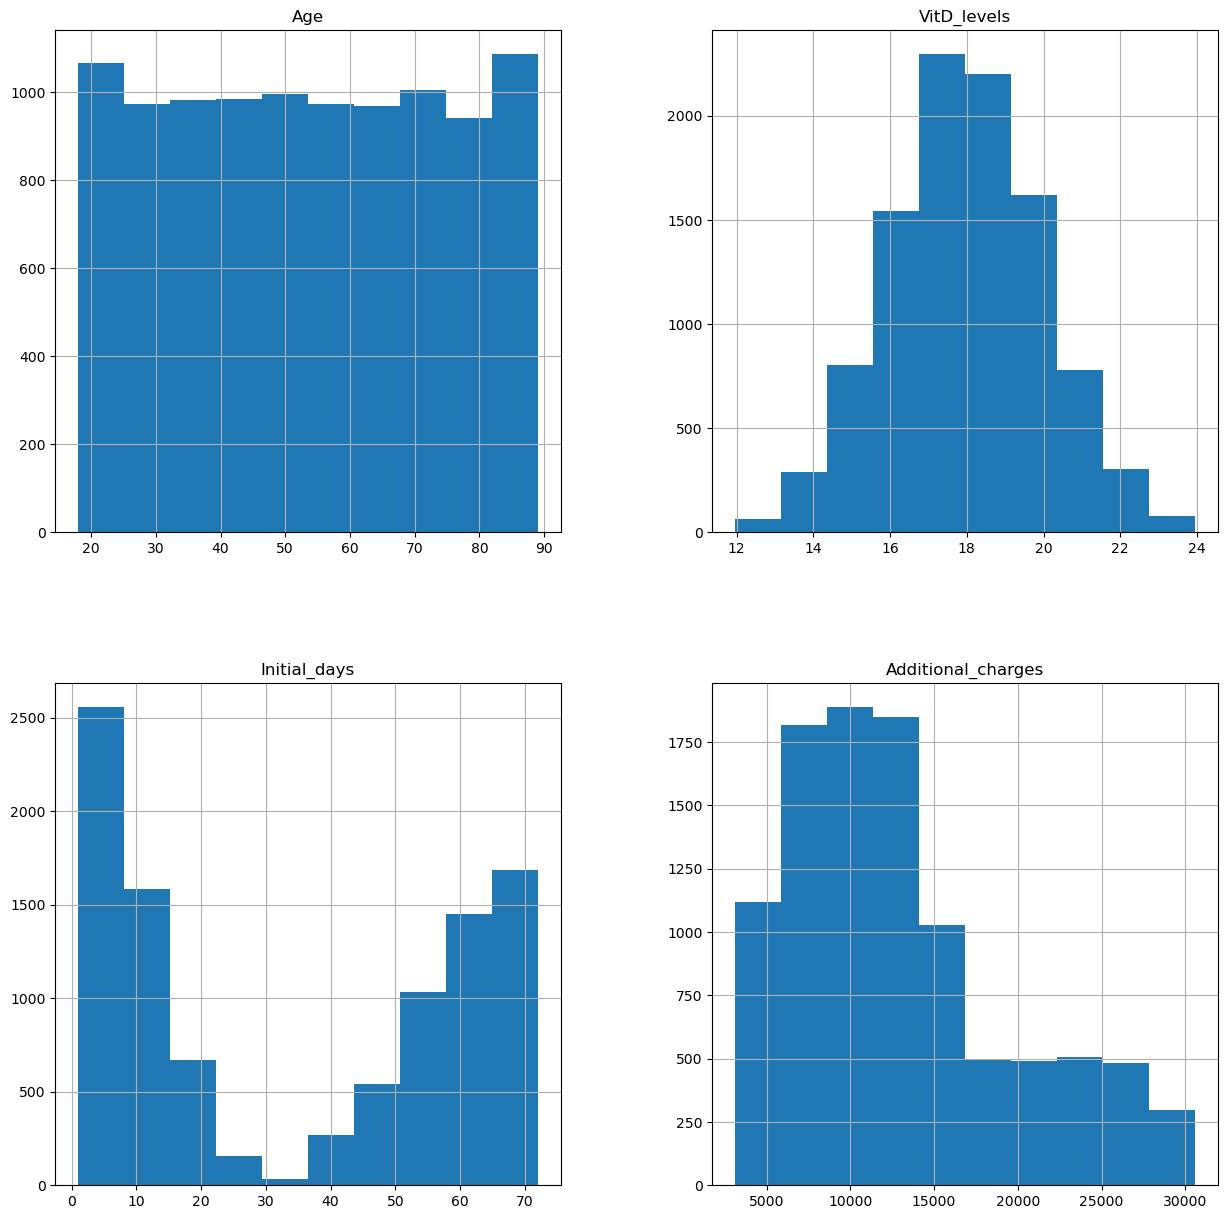

In [14]:
#distribution visualization
df.hist(figsize = (15,15))

In [15]:
#summary for categorical Area
df.Area.value_counts()

Area
Rural       3360
Suburban    3321
Urban       3295
Name: count, dtype: int64

In [16]:
#summary for categorical Gender
df.Gender.value_counts()

Gender
Female       5002
Male         4761
Nonbinary     213
Name: count, dtype: int64

In [17]:
#summary for categorica ReAdmis
df.ReAdmis.value_counts()

ReAdmis
0    6317
1    3659
Name: count, dtype: int64

In [18]:
#summary for categorical Initial_admin
df.Initial_admin.value_counts()

Initial_admin
Emergency Admission      5052
Elective Admission       2495
Observation Admission    2429
Name: count, dtype: int64

In [19]:
#summary for categorical HighBlood
df.HighBlood.value_counts()

HighBlood
0    5900
1    4076
Name: count, dtype: int64

In [20]:
#summary for categorical Stroke
df.Stroke.value_counts()

Stroke
0    7988
1    1988
Name: count, dtype: int64

In [21]:
#summary for categorical Complication_risk
df.Complication_risk.value_counts()

Complication_risk
Medium    4507
High      3350
Low       2119
Name: count, dtype: int64

In [22]:
#summary for categorical Overweight
df.Overweight.value_counts()

Overweight
1    7078
0    2898
Name: count, dtype: int64

In [23]:
#summary for categorical Arthritis
df.Arthritis.value_counts()

Arthritis
0    6410
1    3566
Name: count, dtype: int64

In [24]:
#summary for categorical Diabetes
df.Diabetes.value_counts()

Diabetes
0    7240
1    2736
Name: count, dtype: int64

In [25]:
#summary for Hyperlipidemia
df.Hyperlipidemia.value_counts()

Hyperlipidemia
0    6611
1    3365
Name: count, dtype: int64

In [26]:
#summary for BackPain
df.BackPain.value_counts()

BackPain
0    5871
1    4105
Name: count, dtype: int64

In [27]:
#summary for Services
df.Services.value_counts()

Services
Blood Work     5257
Intravenous    3123
CT Scan        1219
MRI             377
Name: count, dtype: int64

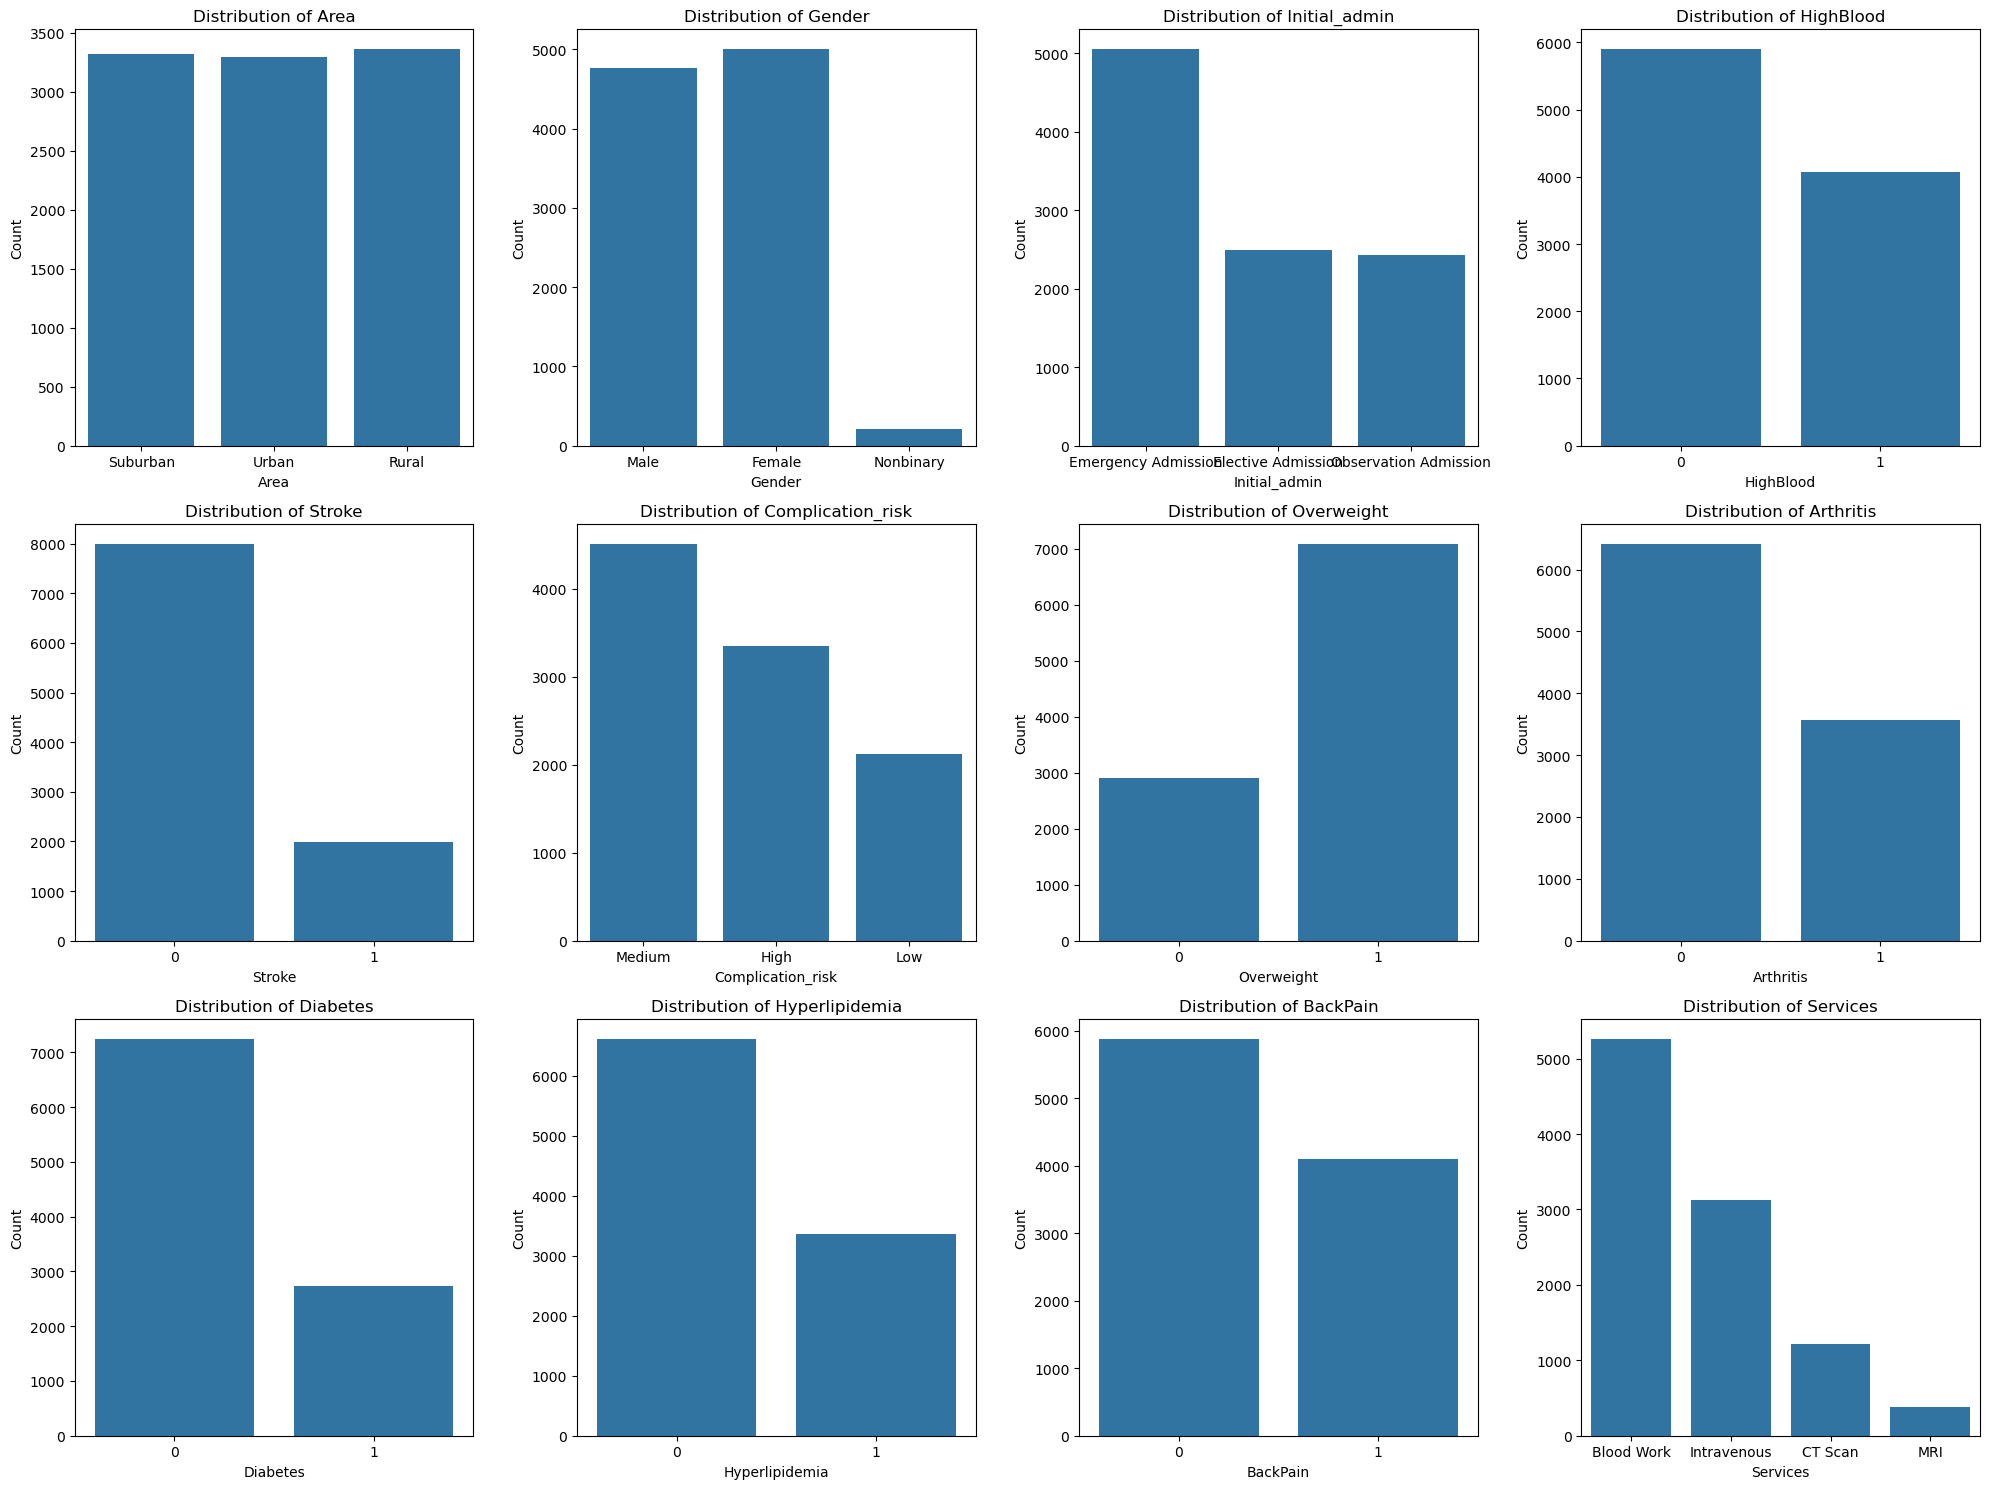

In [28]:
#list of categorical variables
categorical_vars = ['Area', 'Gender', 'Initial_admin', 'HighBlood', 'Stroke', 'Complication_risk', 'Overweight', 'Arthritis', 'Diabetes', 'Hyperlipidemia', 'BackPain', 'Services']

#set up the matplotlib figure with a grid layout
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))

#flatten the axes array for easy iteration
axes = axes.flatten()

#create bar plots for each categorical variable
for i, var in enumerate(categorical_vars):
    sns.countplot(data=df, x=var, ax=axes[i])
    axes[i].set_title(f'Distribution of {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Count')

#remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [29]:
#generate column names which are pythonic in syntax and descriptive
pythonic_columns = ['area_type', 'age', 'gender', 'readmission', 'vitamin_d_level', 'initial_admission_type', 'high_bp', 'stroke', 'complication_risk', 'overweight', 'arthritis', 'diabetes', 'hyperlipidemia', 'back_pain', 'services_type', 'days_hospitalized', 'additional_charges' ]

#implement new pythonic column headings
df.columns = pythonic_columns

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9976 entries, 1 to 10000
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   area_type               9976 non-null   object 
 1   age                     9976 non-null   int64  
 2   gender                  9976 non-null   object 
 3   readmission             9976 non-null   object 
 4   vitamin_d_level         9976 non-null   float64
 5   initial_admission_type  9976 non-null   object 
 6   high_bp                 9976 non-null   object 
 7   stroke                  9976 non-null   object 
 8   complication_risk       9976 non-null   object 
 9   overweight              9976 non-null   object 
 10  arthritis               9976 non-null   object 
 11  diabetes                9976 non-null   object 
 12  hyperlipidemia          9976 non-null   object 
 13  back_pain               9976 non-null   object 
 14  services_type           9976 non-null   obje

In [31]:
#set the pandas option to opt-in to the future behavior
pd.set_option('future.no_silent_downcasting', True)

#One Hot Encoding using get_dummies
df = pd.get_dummies(df, columns=['area_type', 'gender', 'initial_admission_type', 'complication_risk', 'services_type'], drop_first=True)

#replace boolean values with integers
df = df.replace({True: 1, False: 0})

#convert all columns to numeric
df = df.apply(pd.to_numeric)


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9976 entries, 1 to 10000
Data columns (total 23 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   age                                           9976 non-null   int64  
 1   readmission                                   9976 non-null   int64  
 2   vitamin_d_level                               9976 non-null   float64
 3   high_bp                                       9976 non-null   int64  
 4   stroke                                        9976 non-null   int64  
 5   overweight                                    9976 non-null   int64  
 6   arthritis                                     9976 non-null   int64  
 7   diabetes                                      9976 non-null   int64  
 8   hyperlipidemia                                9976 non-null   int64  
 9   back_pain                                     9976 non-null   int64

In [33]:
#save dataframe to csv
df.to_csv('D209task2_clean.csv', index=False)

In [34]:
#assign all predictor variables to X and dependent readmission to y 
X = df.drop(["readmission"], axis=1).copy()
y = df['readmission'].copy()
#view the spape of X and y
print(X.shape)
print(y.shape)

(9976, 22)
(9976,)


In [35]:
#split the data into train and test sets (80% train/20% test) 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size=0.2, random_state = 42, stratify = y)
#view shape of the sets
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7980, 22)
(1996, 22)
(7980,)
(1996,)


In [36]:
#save each of the four data sets to csv
X_train.to_csv('task2_Xtrain.csv', index=False)
X_test.to_csv('task2_Xtest.csv', index=False)
y_train.to_csv('task2_ytrain.csv', index=False)
y_test.to_csv('task2_ytest.csv', index=False)

In [37]:
#define the hyperparameter grid 
param_grid = {
    'max_depth' : [2, 3, 4, 5],
    'min_samples_leaf' : [1, 2, 3, 4]
}

#create a decision tree classifier
clf = DecisionTreeClassifier()

#perform grid search using 5-fold cross-validation
grid_search = GridSearchCV(clf, param_grid, cv=5)

#train the model on the training data 
grid_search.fit(X_train, y_train)

#predict the class labels of the testing data using the best model
y_pred = grid_search.predict(X_test)

#calculate the accuracy and AUC of the best model
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

#print accuracy and auc
print("Accuracy:", accuracy)
print("AUC:", auc)

#print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

Accuracy: 0.9754509018036072
AUC: 0.9745797883378294
Best hyperparameters: {'max_depth': 4, 'min_samples_leaf': 2}


In [38]:
#fit the DT model with hyperparameters 'max_depth': 4, 'min_samples_leaf': 2
dt = DecisionTreeClassifier(max_depth = 4, min_samples_leaf = 2)

#fit the model to the training data
dt.fit(X_train, y_train)

#make predictions on the test data
y_pred = dt.predict(X_test)

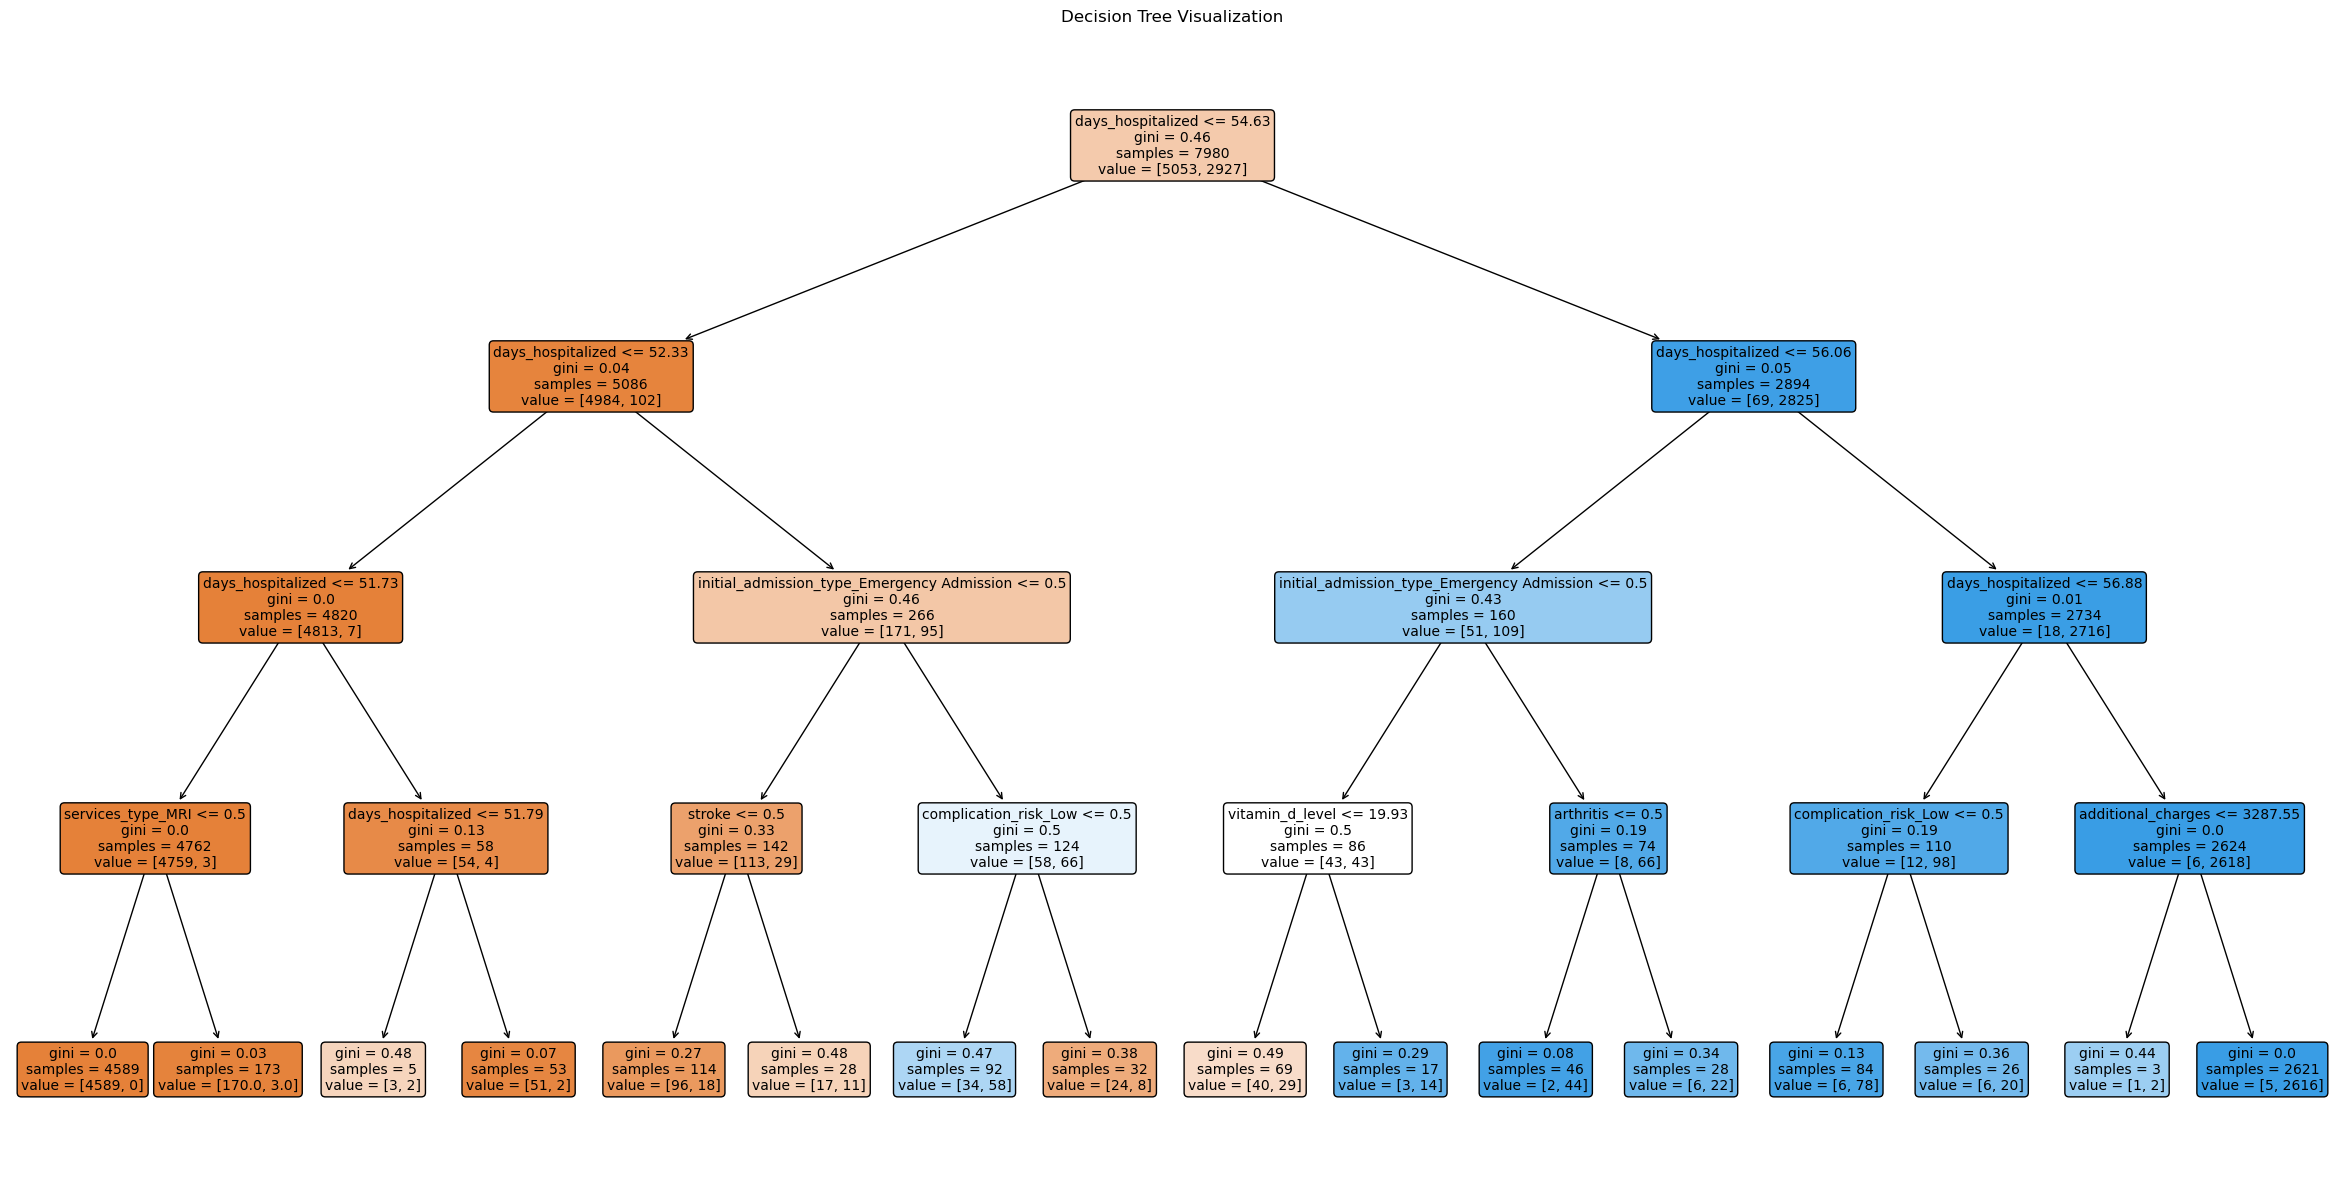

In [39]:
#plot the decision tree 
plt.figure(figsize=(30, 15))  
decision_tree = grid_search.best_estimator_
plot_tree(decision_tree, filled=True, fontsize=10,
          feature_names=X.columns, proportion=False,
          rounded=True, precision=2)  
plt.title("Decision Tree Visualization")  
plt.show()

In [40]:
#get a classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1264
           1       0.96      0.97      0.97       732

    accuracy                           0.98      1996
   macro avg       0.97      0.97      0.97      1996
weighted avg       0.98      0.98      0.98      1996



In [41]:
#calculate the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
print(cnf_matrix)

[[1236   28]
 [  21  711]]


Text(0.5, 23.52222222222222, 'Predicted')

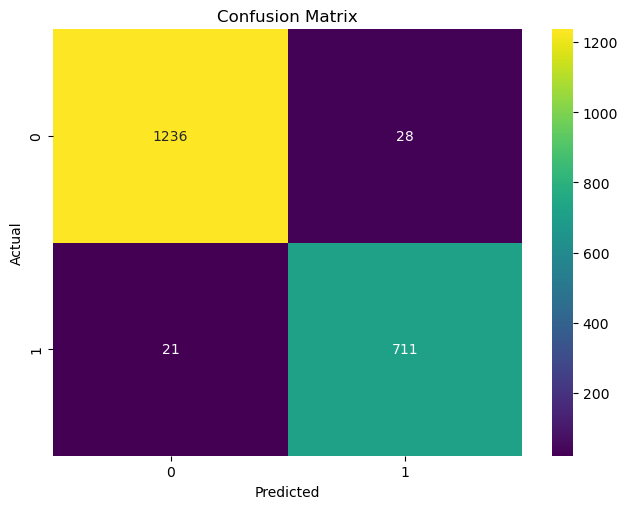

In [42]:
#create a confusion matrix heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, fmt = 'g', cmap='viridis')
plt.tight_layout()
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [43]:
#predict the class labels for the training and testing datasets using the optimal model
y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)

#determine the accuracy of the optimal model on both the training and testing datasets
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

#print the accuracy
print("Training set accuracy:", accuracy_train)
print("Test set accuracy:", accuracy_test)

Training set accuracy: 0.9829573934837093
Test set accuracy: 0.9754509018036072


In [44]:
#get AUC-ROC score 
auc_roc = roc_auc_score(y_test, y_pred)
print("AUC-ROC score:", auc_roc)

AUC-ROC score: 0.9745797883378294


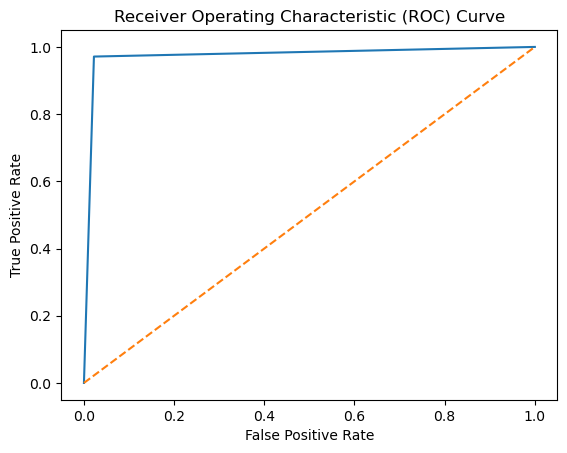

In [45]:
#plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

In [46]:
#calculate MSE and RMSE
mse_dt = mean_squared_error(y_test, y_pred)
rmse_dt = mse_dt**(1/2)

print("Accuracy: ", dt.score(X_test, y_test))
print("Mean squared error: ", mse_dt)
print("Root mean squared error: ", rmse_dt)

Accuracy:  0.9754509018036072
Mean squared error:  0.024549098196392786
Root mean squared error:  0.15668151836254582
